## Description:

    Use DeSeq2 to identify differential abundance between fertilizer treatments at T3 
   


# Setting variables

In [1]:
workDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "phyloseq", "dplyr", "tidyr", 
           "reshape2", "vegan", "RColorBrewer", "VennDiagram")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.2’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.1’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.19.1’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.6.0’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.3’
[1] "RColorBrewer"
[1] ‘1.1.2’
[1] "VennDiagram"
[1] ‘1.6.17’


In [7]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [8]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [9]:
%%R

# Set rep and R_Year as a factor
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$R_Year = factor(sample_data(physeq.Full)$R_Year)  

#remove BARE soil controls and untreated seeds
physeq.bare = subset_samples(physeq.Full, Genotype == "Bare")
physeq.plant = subset_samples(physeq.Full, Genotype != "Bare" & SeedTreatment == "Treated")





#re-order levels 
sample_data(physeq.plant)$R_Year %>% levels


 [1] "1936" "1939" "1942" "1953" "1961" "1971" "1975" "1984" "1991" "2001"
[11] "2003" "2011"


In [10]:
%%R
physeq.bare

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [19]:
%%R
l2f.rhiz = read.csv(file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/BarevsHybrid.csv", header = TRUE)

In [21]:
%%R

Rhiz.sig = l2f.rhiz %>% filter(p.adj < .05)

In [22]:
%%R
# list of OTUs enriched in the rhizosphere
RhizEnriched = filter(Rhiz.sig, log2FoldChange > 0) %>%
            .$OTU %>%
            unique()

# list of OTUs enriched in the rhizosphere at T1 or T2 so fertilizer at T3 doesn't weight
RhizEnriched.t1_2 = filter(Rhiz.sig, log2FoldChange > 0 & TimePoint %in% c("T1", "T2")) %>%
            .$OTU %>%
            unique()

length(RhizEnriched)

[1] 284


# differential abundance at T3

## bare soil

In [11]:
%%R
physeq.bare.t3 = subset_samples(physeq.bare, TimePoint == "T3")

sample_data(physeq.bare.t3)$Rep = factor(sample_data(physeq.bare.t3)$Rep)
sample_data(physeq.bare.t3)$Fert = factor(sample_data(physeq.bare.t3)$Fert)

In [12]:
%%R

baredds = phyloseq_to_deseq2(physeq.bare.t3, ~ Rep + Fert)
# calculate geometric means prior to estimate size factors
#gm_mean = function(x, na.rm=TRUE){
#  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
#}
#geoMeans = apply(counts(diagdds), 1, gm_mean)
#diagdds = estimateSizeFactors(diagdds, geoMeans = geoMeans)
baredds = DESeq(baredds, fitType="local")

/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: final dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/brya

In [13]:
%%R
bare_res85 = results(baredds, contrast=c("Fert", "85", "0"), alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
bare_res170 = results(baredds, contrast=c("Fert", "170", "0"), alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)

In [14]:
%%R
summary(bare_res85)


out of 4326 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 1, 0.023% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [15]:
%%R
summary(bare_res170)


out of 4326 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 0, 0% 
LFC < 0 (down)   : 0, 0% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [16]:
%%R
TT = tax_table(physeq.bare.t3) %>%
    as.data.frame %>%
    mutate(OTU = rownames(.))
head(TT)

     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
             Rank5           Rank6        Rank7
1 __Nannocystineae __Haliangiaceae __Haliangium
2 __Nannocystineae __Haliangiaceae __Haliangium
3 __Nannocystineae __Haliangiaceae __Haliangium
4 __Nannocystineae __Haliangiaceae __Haliangium
5 __Nannocystineae __Haliangiaceae __Haliangium
6 __Nannocystineae __Haliangiaceae __Haliangium
                               Rank8       OTU
1             __uncultured_bacterium   OTU.871
2                               <NA>  OTU.9547
3 __uncultured_delta_proteobacterium   OTU.523
4 __uncultured_delta_

In [17]:
%%R
bare_res85$OTU = rownames(bare_res85)
bare_res85$Contrast = "0_85"
bare_res170$OTU = rownames(bare_res170)
bare_res170$Contrast = "0_170"
l2f.bare.Fert = rbind(bare_res85, bare_res170) %>% as.data.frame


l2f.bare.Fert = left_join(l2f.bare.Fert, TT, by = "OTU")

In [23]:
%%R
#Number of otus depleted in fertilized plots
BareFert.sig = filter(l2f.bare.Fert, padj < 0.05)
BareFert.sig %>% filter(log2FoldChange < 0) %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs depleted in bare soil fertilized plots") %>% print

#Number of otus enriched in fertilized plots that are rhizosphere repsonders at any point
BareFert.sig %>% filter(log2FoldChange > 0) %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs enriched in  bare soil fertilized plots") %>% print


BareFert.sig %>% filter(log2FoldChange > 0 & OTU %in% RhizEnriched) %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs enriched in  bare soil fertilized plots that are also rhizosphere responders") %>% print

# Depleted_responders = Fert.sig %>% filter(log2FoldChange < 0 & OTU %in% RhizEnriched.t1_2) 

# Depleted_responders %>% .$OTU %>% unique() %>% length %>% 
#         paste(., "OTUs depleted in fertilized plots that are also rhizosphere responders at T1 or T2") %>% print

# Depleted_responders

[1] "1 OTUs depleted in bare soil fertilized plots"
[1] "0 OTUs enriched in  bare soil fertilized plots"
[1] "0 OTUs enriched in  bare soil fertilized plots that are also rhizosphere responders"


In [24]:
%%R

BareFert.sig %>% filter(log2FoldChange < 0) 

  baseMean log2FoldChange     lfcSE      stat       pvalue      padj     OTU
1  18.6089      -1.484654 0.3366368 -4.410253 1.032499e-05 0.0446659 OTU.399
  Contrast    Rank1            Rank2                Rank3           Rank4
1     0_85 Bacteria __Proteobacteria __Betaproteobacteria __Rhodocyclales
             Rank5        Rank6                  Rank7 Rank8
1 __Rhodocyclaceae __uncultured __uncultured_bacterium  <NA>


## Rhizosphere

In [25]:
%%R
physeq.plant.t3 = subset_samples(physeq.plant, TimePoint == "T3")
sample_data(physeq.plant.t3)$R_Year = factor(sample_data(physeq.plant.t3)$R_Year)
sample_data(physeq.plant.t3)$Genotype = factor(sample_data(physeq.plant.t3)$Genotype)
sample_data(physeq.plant.t3)$Rep = factor(sample_data(physeq.plant.t3)$Rep)
sample_data(physeq.plant.t3)$Fert = factor(sample_data(physeq.plant.t3)$Fert)

In [26]:
%%R

plantdds = phyloseq_to_deseq2(physeq.plant.t3, ~ Rep + Genotype + Fert)

plantdds = DESeq(plantdds, fitType="local")

In [27]:
%%R
resultsNames(plantdds)

 [1] "Intercept"    "Rep1"         "Rep2"         "Rep3"         "Rep4"        
 [6] "Genotype1939" "Genotype1953" "Genotype1971" "Genotype1984" "Genotype2001"
[11] "Genotype2011" "Fert0"        "Fert85"       "Fert170"     


In [28]:
%%R

res85 = results(plantdds, contrast=c("Fert", "85", "0"), alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)
res170 = results(plantdds, contrast=c("Fert", "170", "0"), alpha = 0.05, 
                independentFiltering = TRUE, parallel = TRUE)

In [29]:
%%R
summary(res85)


out of 4590 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 25, 0.54% 
LFC < 0 (down)   : 4, 0.087% 
outliers [1]     : 0, 0% 
low counts [2]   : 2314, 50% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [30]:
%%R
summary(res170)


out of 4590 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 83, 1.8% 
LFC < 0 (down)   : 21, 0.46% 
outliers [1]     : 0, 0% 
low counts [2]   : 1424, 31% 
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [31]:
%%R
TT = tax_table(physeq.plant.t3) %>%
    as.data.frame %>%
    mutate(OTU = rownames(.))
head(TT)

     Rank1            Rank2                 Rank3          Rank4
1 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
2 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
3 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
4 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
5 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
6 Bacteria __Proteobacteria __Deltaproteobacteria __Myxococcales
             Rank5           Rank6        Rank7
1 __Nannocystineae __Haliangiaceae __Haliangium
2 __Nannocystineae __Haliangiaceae __Haliangium
3 __Nannocystineae __Haliangiaceae __Haliangium
4 __Nannocystineae __Haliangiaceae __Haliangium
5 __Nannocystineae __Haliangiaceae __Haliangium
6 __Nannocystineae __Haliangiaceae __Haliangium
                               Rank8       OTU
1             __uncultured_bacterium   OTU.871
2                               <NA>  OTU.9547
3 __uncultured_delta_proteobacterium   OTU.523
4 __uncultured_delta_

In [32]:
%%R
res85$OTU = rownames(res85)
res85$Contrast = "0_85"
res170$OTU = rownames(res170)
res170$Contrast = "0_170"
l2f.Fert = rbind(res85, res170) %>% as.data.frame


l2f.Fert = left_join(l2f.Fert, TT, by = "OTU")

In [34]:
%%R
#df_plant.t1$p.adj = p.adjust(df_plant.t1$pvalue, "BH")
head(l2f.Fert) %>% print
tail(l2f.Fert) %>% print



    baseMean log2FoldChange     lfcSE       stat      pvalue      padj
1  7.0919597     -0.5366518 0.2066106 -2.5974072 0.009393051 0.2878374
2  0.5654074     -0.2243810 0.3850527 -0.5827281 0.560076326        NA
3 14.6904237     -0.2146339 0.1473315 -1.4568089 0.145169138 0.7854952
4  2.9451143     -0.2864698 0.2823308 -1.0146603 0.310267776 0.8813793
5  1.1655532     -0.2565499 0.3659256 -0.7010985 0.483241557        NA
6  2.4309638     -0.3636330 0.2826494 -1.2865162 0.198262977 0.8393963
        OTU Contrast    Rank1            Rank2                 Rank3
1   OTU.871     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
2  OTU.9547     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
3   OTU.523     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
4  OTU.1107     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
5 OTU.11742     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
6  OTU.1889     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
           Rank4    

In [51]:
%%R
write.csv(l2f.Fert, file = "/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_fert_t3.csv")

In [36]:
%%R
Fert.sig = l2f.Fert %>% filter(padj < .05)
    Fert.sig %>% head %>% print

    baseMean log2FoldChange      lfcSE     stat       pvalue        padj
1  57.336477      0.3088018 0.09036034 3.417448 6.321110e-04 0.049772638
2  31.608509      1.3851356 0.33690111 4.111401 3.932652e-05 0.005594198
3  33.698029      1.1325439 0.32376969 3.497992 4.687744e-04 0.041035789
4 175.345301      0.7820358 0.19220954 4.068663 4.728374e-05 0.006330458
5  95.511586      0.8416117 0.21868204 3.848563 1.188125e-04 0.013520866
6   6.678833      1.4443268 0.34166679 4.227296 2.365160e-05 0.004364670
        OTU Contrast    Rank1            Rank2                 Rank3
1  OTU.2489     0_85 Bacteria __Proteobacteria __Deltaproteobacteria
2 OTU.14139     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
3 OTU.15685     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
4    OTU.69     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
5    OTU.78     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
6  OTU.3468     0_85 Bacteria __Proteobacteria __Alphaproteobacteria
      

/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  Ignoring unknown aesthetics: position

  warnings.warn(x, RRuntimeWarning)


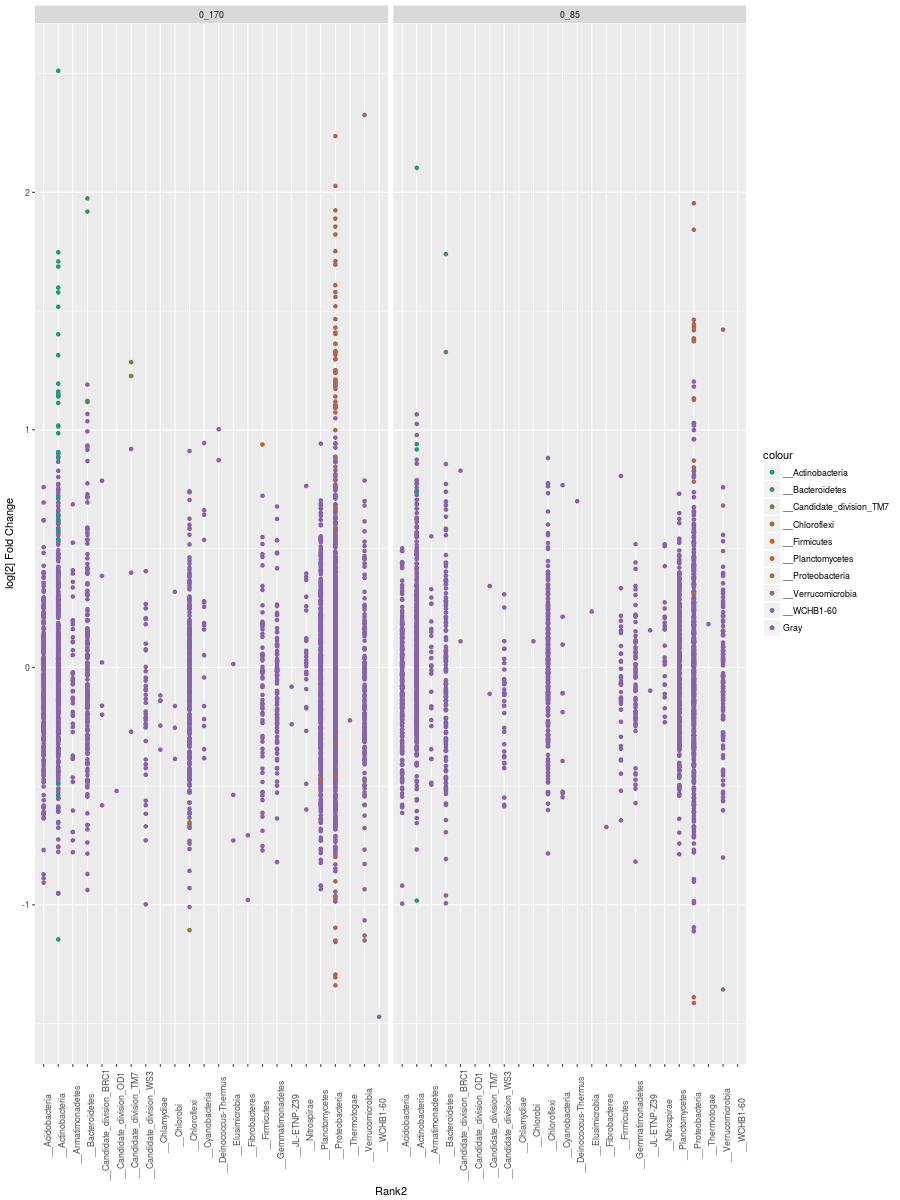

In [37]:
%%R -w 900 -h 1200
#df.adj = df_plant.t1[!is.na(df_plant.t1$padj),]

df.sig = l2f.Fert %>% filter(padj < .05)
df.ns = l2f.Fert %>% filter(padj >= .05)
colourCount = length(unique(df.sig$Rank2))
colourCount = length(unique(l2f.Fert$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(l2f.Fert)+
    geom_point(data = df.ns, aes(Rank2, log2FoldChange, color = "Gray", position = "jitter")) +
    scale_shape_identity() +
    geom_point(data = df.sig, aes(Rank2, log2FoldChange, color = Rank2, position = "jitter")) +
    
               #geom_hline(y_intercept = .4) +
    
    facet_wrap(~Contrast)+
    theme(axis.text.x = element_text(angle = 90)) +
    labs(y = "log[2] Fold Change") 

p = p + scale_color_manual(values = getPalette(colourCount))

df.sig = NULL
df.ns = NULL
#p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)
#p = p + theme_bw()




#p = p + geom_hline(y = l2fc.threshold)



#p = p + theme(axis.text.x = element_blank())

#p = p + labs(x = "Phylum", color = "Phylum")

#p = p + guides(col = guide_legend(ncol = 2))

#p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

#p = p + guides(colour = guide_legend(override.aes = list(size=4)))

p

In [ ]:
## OTUs depleted in fertilized treatments

In [38]:
%%R
#Number of otus depleted in fertilized plots
Fert.sig %>% filter(log2FoldChange < 0) %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs depleted in fertilized plots") %>% print

#Number of otus depleted in fertilized plots that are rhizosphere repsonders at any point
Fert.sig %>% filter(log2FoldChange < 0 & OTU %in% RhizEnriched) %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs depleted in fertilized plots that are also rhizosphere responders") %>% print

Depleted_responders = Fert.sig %>% filter(log2FoldChange < 0 & OTU %in% RhizEnriched.t1_2) 

Depleted_responders %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs depleted in fertilized plots that are also rhizosphere responders at T1 or T2") %>% print

Depleted_responders

[1] "23 OTUs depleted in fertilized plots"
[1] "7 OTUs depleted in fertilized plots that are also rhizosphere responders"
[1] "4 OTUs depleted in fertilized plots that are also rhizosphere responders at T1 or T2"
  baseMean log2FoldChange     lfcSE      stat       pvalue         padj     OTU
1  9.04846     -0.9006545 0.2816683 -3.197572 1.385900e-03 0.0439099548 OTU.613
2 17.19523     -1.1293054 0.2714858 -4.159723 3.186343e-05 0.0024018958 OTU.500
3 19.06640     -0.6527816 0.2052594 -3.180277 1.471346e-03 0.0452260194 OTU.848
4 11.64357     -1.1063480 0.2329514 -4.749265 2.041573e-06 0.0002393934 OTU.400
  Contrast    Rank1             Rank2                 Rank3
1    0_170 Bacteria  __Proteobacteria __Deltaproteobacteria
2    0_170 Bacteria __Verrucomicrobia            __Opitutae
3    0_170 Bacteria     __Chloroflexi      __Chloroflexales
4    0_170 Bacteria     __Chloroflexi      __Chloroflexales
                  Rank4            Rank5                  Rank6
1        __Myxococcales

In [39]:
%%R
#Number of otus enriched in fertilized plots
FertResponders = Fert.sig %>% filter(log2FoldChange > 0) %>% .$OTU %>% unique()  
FertResponders %>% length %>% paste(., "OTUs enriched in fertilized plots") %>% print

#Number of otus enriched at either fertilization level:
FertResponders = Fert.sig %>% filter(log2FoldChange > 0 & Contrast == "0_85") %>% .$OTU %>% unique()  
FertResponders %>% length %>% paste(., "OTUs enriched at 85kg N/ha fertilized plots") %>% print

FertResponders = Fert.sig %>% filter(log2FoldChange > 0 & Contrast == "0_170") %>% .$OTU %>% unique()  
FertResponders %>% length %>% paste(., "OTUs enriched at 170kg N/ha fertilized plots") %>% print

#Number of otus enriched in fertilized plots that are rhizosphere repsonders at any point
Enriched_responders = Fert.sig %>% filter(log2FoldChange > 0 & OTU %in% RhizEnriched) %>% .$OTU %>% unique()  
        paste(length(Enriched_responders), "OTUs enriched in fertilized plots that are also rhizosphere responders") %>% print

Enriched_responders.t1_2 = Fert.sig %>% filter(log2FoldChange > 0 & OTU %in% RhizEnriched.t1_2) %>% unique

Enriched_responders.t1_2 %>% .$OTU %>% unique() %>% length %>% 
        paste(., "OTUs enriched in fertilized plots that are also rhizosphere responders at T1 or T2") %>% print

Enriched_responders 

[1] "88 OTUs enriched in fertilized plots"
[1] "25 OTUs enriched at 85kg N/ha fertilized plots"
[1] "83 OTUs enriched at 170kg N/ha fertilized plots"
[1] "64 OTUs enriched in fertilized plots that are also rhizosphere responders"
[1] "41 OTUs enriched in fertilized plots that are also rhizosphere responders at T1 or T2"
 [1] "OTU.14139" "OTU.15685" "OTU.69"    "OTU.78"    "OTU.3468"  "OTU.495"  
 [7] "OTU.287"   "OTU.267"   "OTU.119"   "OTU.5502"  "OTU.11319" "OTU.3521" 
[13] "OTU.11"    "OTU.5756"  "OTU.14"    "OTU.484"   "OTU.10"    "OTU.218"  
[19] "OTU.94"    "OTU.4"     "OTU.3889"  "OTU.314"   "OTU.91"    "OTU.1372" 
[25] "OTU.844"   "OTU.2204"  "OTU.553"   "OTU.12"    "OTU.260"   "OTU.1482" 
[31] "OTU.1411"  "OTU.694"   "OTU.5535"  "OTU.4143"  "OTU.509"   "OTU.188"  
[37] "OTU.3543"  "OTU.11278" "OTU.357"   "OTU.163"   "OTU.1529"  "OTU.407"  
[43] "OTU.923"   "OTU.1808"  "OTU.172"   "OTU.169"   "OTU.459"   "OTU.295"  
[49] "OTU.4019"  "OTU.10034" "OTU.14827" "OTU.5"     "OTU.1012

In [40]:
%%R
#Fertilizer responders that are not rhizosphere responders at t1 or t2:
Enriched_non_responders = Fert.sig %>% filter(log2FoldChange > 0 & !OTU %in% RhizEnriched)
Enriched_non_responders

      baseMean log2FoldChange      lfcSE     stat       pvalue         padj
1   57.3364770      0.3088018 0.09036034 3.417448 6.321110e-04 0.0497726377
2    4.6717326      1.3820479 0.36249936 3.812553 1.375389e-04 0.0149065996
3   54.3873396      0.4896057 0.13115473 3.733039 1.891835e-04 0.0187209380
4   26.5477688      0.6811600 0.17449482 3.903612 9.476769e-05 0.0113521719
5    2.9692605      1.4034086 0.31067578 4.517277 6.263991e-06 0.0006834449
6    2.7249295      1.2006362 0.35842767 3.349731 8.089017e-04 0.0304878910
7    1.5300740      1.3614809 0.36701811 3.709574 2.076083e-04 0.0109547961
8    4.9230742      1.0731758 0.30922435 3.470541 5.194110e-04 0.0210827576
9   22.3371557      0.5853601 0.18281168 3.201984 1.364845e-03 0.0439099548
10   1.6826509      1.4659428 0.38181408 3.839415 1.233276e-04 0.0072306527
11   1.3505475      1.2979404 0.36960915 3.511657 4.453232e-04 0.0193136051
12   1.2802340      1.1918366 0.36032972 3.307628 9.408975e-04 0.0342400166
13   1.04817

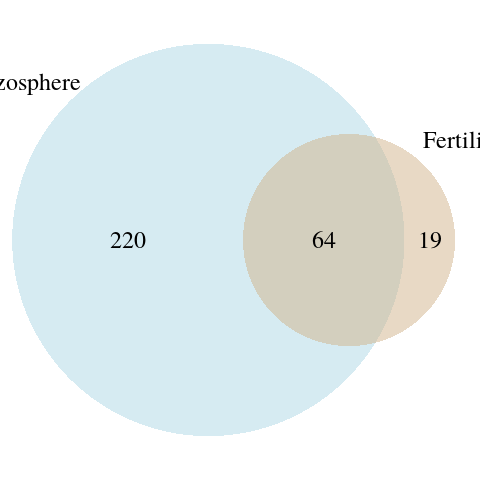

In [41]:
%%R
grid.newpage()
pV = draw.pairwise.venn(area1 = length(RhizEnriched), area2 = length(FertResponders), cross.area = length(Enriched_responders),
                   category = c("Rhizosphere", "Fertilizer"), lty = rep("blank", 2), 
                 fill = c("lightblue", "tan"), alpha = rep(0.5, 2), cex = 2,
                   cat.dist = .05, cat.cex = 2, scaled = TRUE, rotation.degree = 0) %>% grobTree

In [85]:
%%R
tiff("/home/bryan/ERA/data/figures/Rhiz_fert_venn.tiff", width = 5.18, height = 5, units = "in", res = 300)
draw.pairwise.venn(area1 = length(RhizEnriched), area2 = length(FertResponders), cross.area = length(Enriched_responders),
                   category = c("Rhizosphere", "Fertilizer"), lty = rep("blank", 2), 
                 fill = c("lightblue", "tan"), alpha = rep(0.5, 2), cex = 2,
                   cat.dist = .05, cat.cex = 2, scaled = TRUE, rotation.degree = 0)
dev.off()

png 
  2 


In [42]:
%%R
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.3 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      stats4    parallel  tools     stats     graphics  grDevices
 [8] utils     datasets  methods   base     

other attached packages:
 [1] VennDiagram_1.6.17         futile.logger_1.4.3       
 [3] RColorBrewer_1.1-2         vegan_2.4-3               
 [5] lattice_0.20-35            permute_0.9-4             
 [7] reshape2_1.4.2             tidyr_0.6.0               
 [9] dplyr_0.5.0                phyloseq_1.19.1           
[11] scales_0.4.1               gridExtra_2.2.1           
[13] ggplo